In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import pickle, joblib
import cv2
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import Lasso
# !pip install scikeras[tensorflow]
# from scikeras.wrappers import KerasClassifier
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier #deprecated
from sklearn.utils import shuffle
from google.colab.patches import cv2_imshow
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, KFold
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab/FYP2023/

Mounted at /content/drive
buildModelJaffe.ipynb  evalCNN_MVP2.ipynb  evalSVM_v2.ipynb    __pycache__
buildModelKdef.ipynb   evalMLP.ipynb	   extractJaffe.ipynb
buildSVMJaffe.ipynb    evalSVM_MVP1.ipynb  landmarks.py
datasets	       evalSVM_MVP2.ipynb  mask.py


In [ ]:
writeDataPath = '/content/drive/MyDrive/Colab/FYP2023/datasets/'

# Load Datasets

In [ ]:
# load from the NPZ files
landmarksJaffe = pd.read_csv(writeDataPath+'features/landmarksJaffe.csv')
croppedJaffe = np.load(writeDataPath+'features/CroppedJaffe.npz')['img']
# faceMaskJaffe = np.load(writeDataPath+'features/faceMaskJaffe.npz')['img']

landmarksKDEF = pd.read_csv(writeDataPath+'features/landmarksKDEF.csv')
croppedKDEF = np.load(writeDataPath+'features/CroppedKDEF.npz')['img']
# faceMaskKDEF = np.load(writeDataPath+'features/faceMaskKDEF.npz')['img']

landmarksCKPLUS = pd.read_csv(writeDataPath+'features/landmarksCKPLUS.csv')
croppedCKPLUS = np.load(writeDataPath+'features/CroppedCKPLUS.npz')['img']
# faceMaskCKPLUS = np.load(writeDataPath+'features/faceMaskCKPLUS.npz')['img']

landmarksCustom = pd.read_csv(writeDataPath+'features/landmarksCustom.csv')
croppedCustom = np.load(writeDataPath+'features/CroppedCustom.npz')['img']
# faceMaskCustom = np.load(writeDataPath+'features/faceMaskCustom.npz')['img']

# landmarksAFFECTNET = pd.read_csv(writeDataPath+'features/landmarksAFFECTNET.csv')
# croppedAFFECTNET = np.load(writeDataPath+'features/CroppedAFFECTNET.npz')['img']
# faceMaskAFFECTNET = np.load(writeDataPath+'features/faceMaskAFFECTNET.npz')['img']

# landmarksFER2013 = pd.read_csv(writeDataPath+'features/landmarksFER2013.csv')
# croppedFER2013 = np.load(writeDataPath+'features/CroppedFER2013.npz')['img']
# faceMaskFER2013 = np.load(writeDataPath+'features/faceMaskFER2013.npz')['img']


# Concatenate datasets

In [ ]:
# stack datasets
# X_img = np.concatenate([croppedJaffe, croppedKDEF, croppedCKPLUS], axis=0)
# X_3D = pd.concat([landmarksJaffe, landmarksKDEF, landmarksCKPLUS], axis=0)
# X_img = np.concatenate([faceMaskJaffe, faceMaskKDEF, faceMaskCKPLUS], axis=0)
# X_3D = pd.concat([landmarksJaffe, landmarksKDEF, landmarksCKPLUS], axis=0)
X_img = np.concatenate([croppedJaffe, croppedKDEF, croppedCKPLUS, croppedCustom], axis=0)
X_3D = pd.concat([landmarksJaffe, landmarksKDEF, landmarksCKPLUS, landmarksCustom], axis=0)
# X_img = np.concatenate([croppedJaffe, croppedKDEF, croppedCKPLUS, croppedAFFECTNET], axis=0)
# X_3D = pd.concat([landmarksJaffe, landmarksKDEF, landmarksCKPLUS, landmarksAFFECTNET], axis=0)
# X_3D = pd.concat([landmarksJaffe, landmarksKDEF, landmarksCKPLUS, landmarksAFFECTNET, landmarksFER2013], axis=0)
# X_3D = X_3D.sample(frac=1.0, random_state=42)

# extract labels
y = X_3D['emotion'].astype('int8')
y_onehot = to_categorical(y)
print(f"X_img shape: {np.shape(X_img)}, X_3D shape: {X_3D.shape}, labels shape: {y.shape}")

X_img shape: (4088, 96, 96, 3), X_3D shape: (4088, 207), labels shape: (4088,)


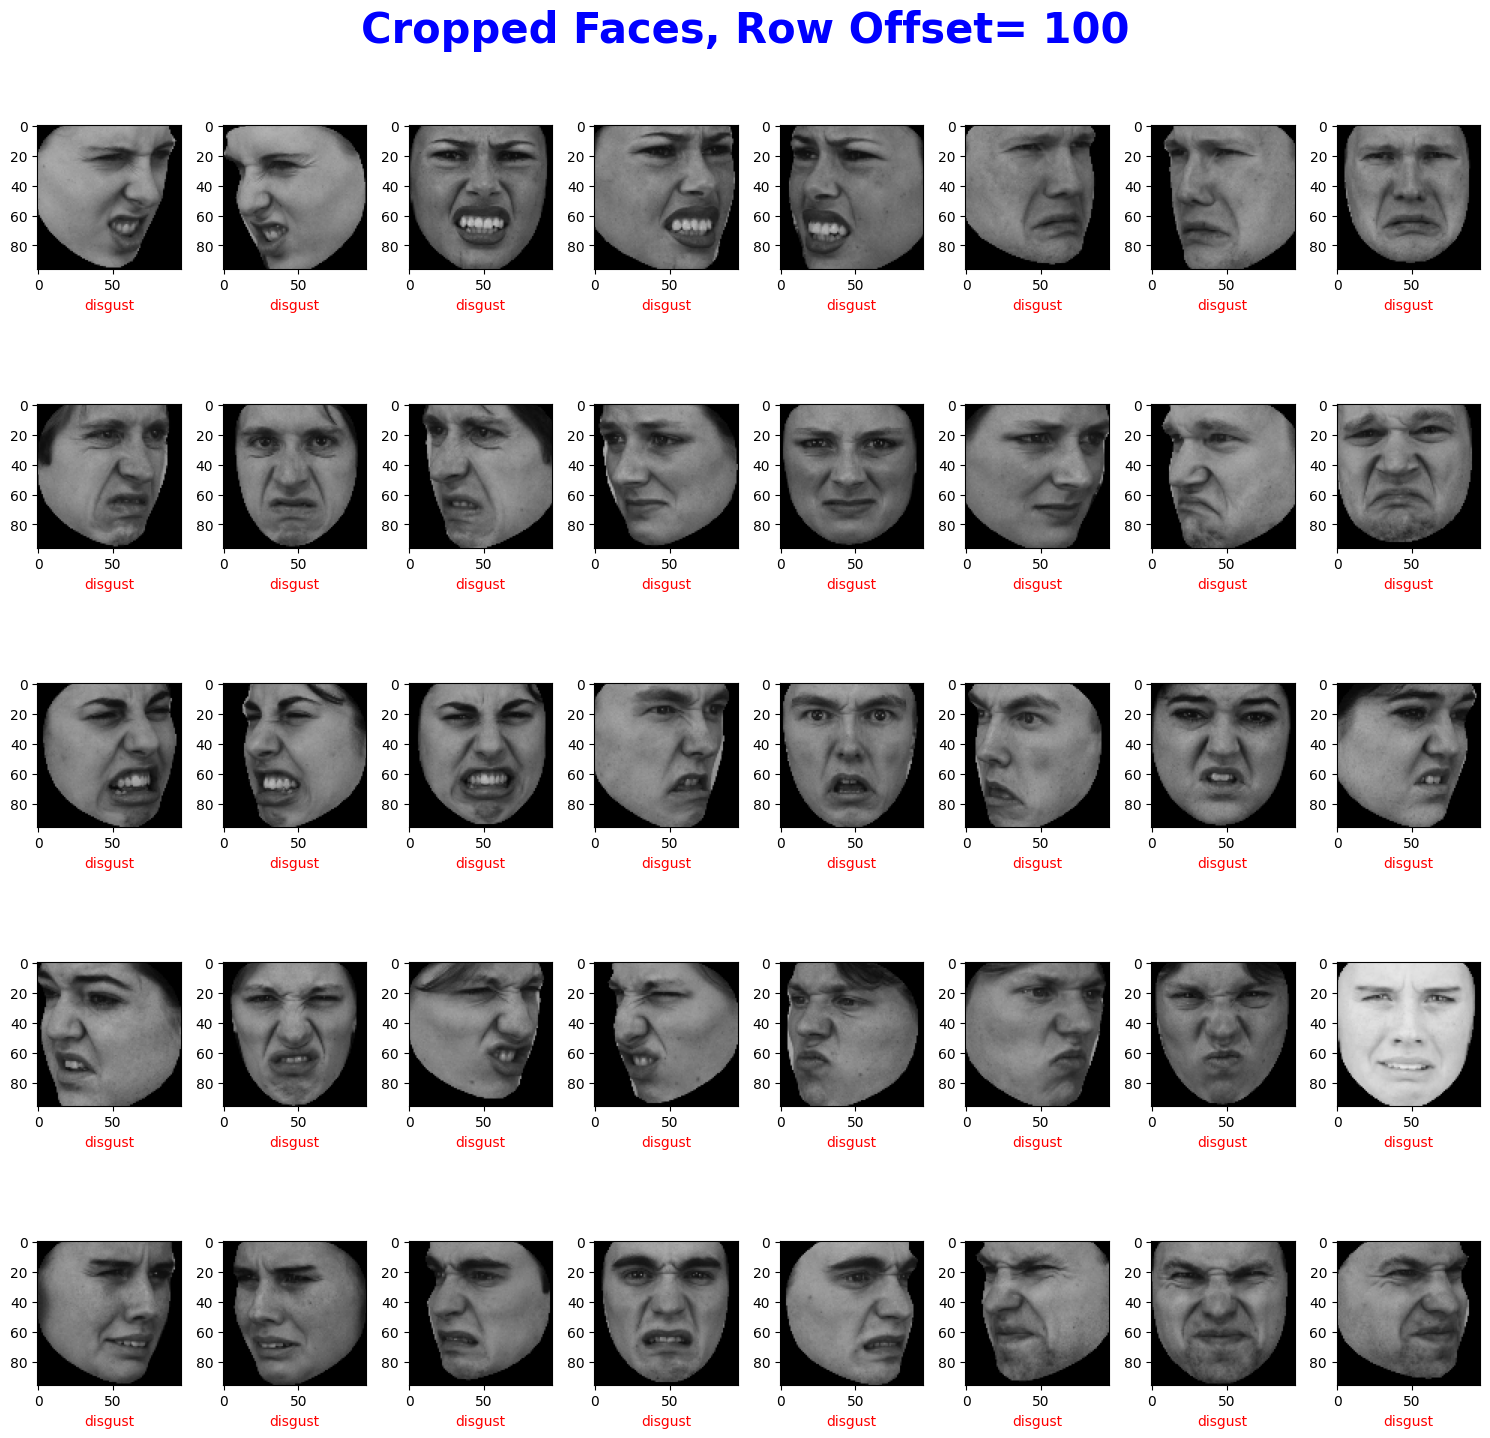

In [ ]:
# A peek at the faces
emo = ['angry',
        'disgust',
        'fear',
        'happy',
        'sad',
        'surprise',
        'neutral'
]

rowOffset = 100
nRows = 5
nCols = 8
fig, axes = plt.subplots(nRows, nCols, figsize=(15, 15))
fig.suptitle(f'Cropped Faces, Row Offset= {rowOffset}', fontsize=30, color='blue', fontweight='bold')
for i in range(nRows):
    for j in range(nCols):
        ax = axes[i, j]
        ax.imshow(X_img[(i+rowOffset)*nCols+j,:,:], cmap='gray')
        ax.set_xlabel(emo[y.iloc[(i+rowOffset)*nCols+j]], c='r')
plt.tight_layout()
plt.show()

# PCA Dimensionality Reduction

In [ ]:
# scale images
X_img_scaled = X_img/255


# CNN Model

In [ ]:
# Define the function to create the model
def createModelCNN():
  model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(96, 96, 1)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation= 'relu'),
    tf.keras.layers.Dense(512, activation= 'relu'),
    tf.keras.layers.Dropout(0.5), #0.2
    tf.keras.layers.Dense(7, activation='softmax'),
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), #0.0001
      loss='categorical_crossentropy',
      metrics=['accuracy'],
  )

  model.summary()

  return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                    

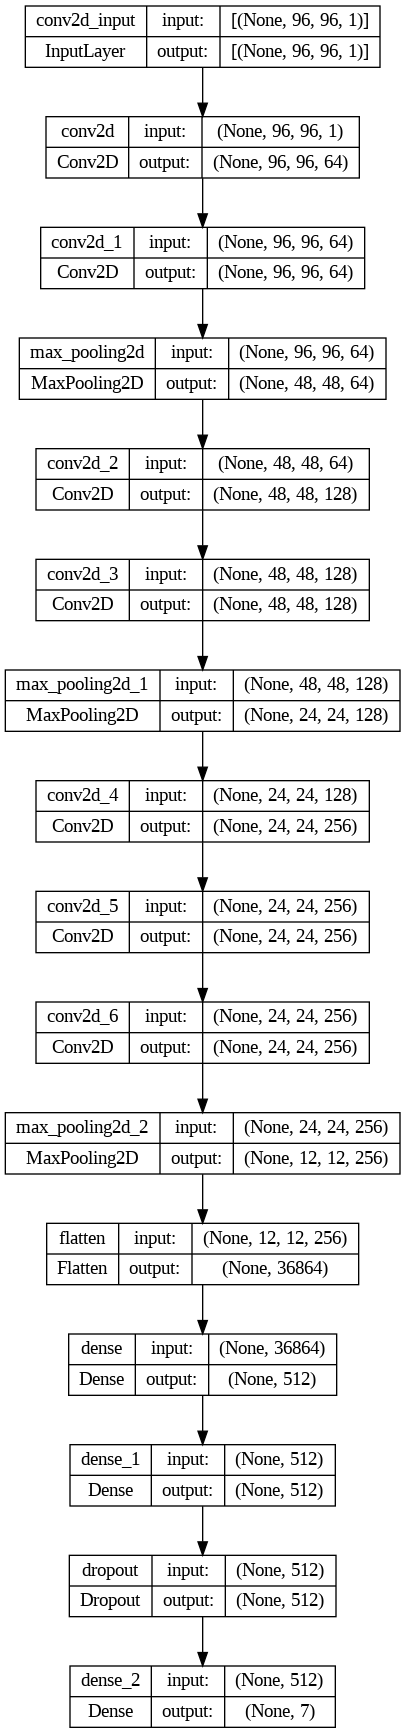

In [ ]:
tf.keras.utils.plot_model(createModelCNN(), "FER MLP PCA Model.png", show_shapes=True)

# CNN Train/Validate Single split

In [ ]:
# split dataset for training & testing
np.random.seed(155)
tf.random.set_seed(142)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_img_scaled[:,:,:,:1], y_onehot, test_size=0.1, shuffle=True, random_state=190)
#256
model = createModelCNN()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 96, 96, 64)        640       
                                                                 
 conv2d_8 (Conv2D)           (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 48, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                  

In [ ]:
# train model
hist = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=30, #100
                    validation_data=(X_test, y_test))

Epoch 1/30
29/29 [==============================] - 32s 449ms/step - loss: 1.9393 - accuracy: 0.1699 - val_loss: 1.9231 - val_accuracy: 0.1540
Epoch 2/30
29/29 [==============================] - 7s 233ms/step - loss: 1.7688 - accuracy: 0.3118 - val_loss: 1.4441 - val_accuracy: 0.4939
Epoch 3/30
29/29 [==============================] - 7s 230ms/step - loss: 1.3611 - accuracy: 0.4860 - val_loss: 1.2282 - val_accuracy: 0.5501
Epoch 4/30
29/29 [==============================] - 7s 234ms/step - loss: 1.1729 - accuracy: 0.5463 - val_loss: 1.0609 - val_accuracy: 0.6406
Epoch 5/30
29/29 [==============================] - 7s 228ms/step - loss: 1.0707 - accuracy: 0.5983 - val_loss: 0.9782 - val_accuracy: 0.6601
Epoch 6/30
29/29 [==============================] - 7s 232ms/step - loss: 0.9723 - accuracy: 0.6331 - val_loss: 0.9011 - val_accuracy: 0.6601
Epoch 7/30
29/29 [==============================] - 7s 232ms/step - loss: 0.8706 - accuracy: 0.6779 - val_loss: 0.8406 - val_accuracy: 0.6968
Epoch

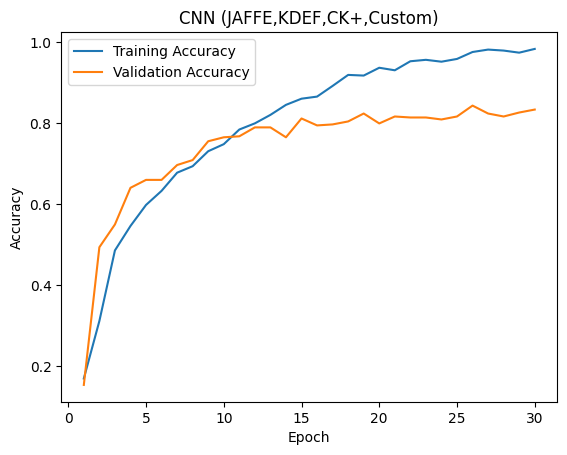

In [ ]:
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = np.arange(1, len(train_acc)+1)

plt.title("CNN (JAFFE,KDEF,CK+,Custom)")
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
y_pred = np.argmax(model.predict(X_test),axis=1)
y_pred
y_testInt = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_testInt, y_pred)

TP = cm.diagonal().sum()
totalIns = cm.sum()

print(f"Number of Test Instances= {totalIns}")
print(f"Accuracy= {round((TP/totalIns)*100,2)}%")
print('Confusion Matrix')
print(cm)

13/13 [==============================] - 1s 15ms/step
Number of Test Instances= 409
Accuracy= 83.37%
Confusion Matrix
[[43  3  1  0  3  0  1]
 [ 4 53  2  0  5  0  0]
 [ 2  5 31  2  3 14  2]
 [ 0  0  1 62  0  0  0]
 [ 2  3  2  0 39  0  6]
 [ 1  0  1  0  0 64  0]
 [ 1  0  2  1  0  1 49]]


# Cross Validation

In [ ]:
# number of folds for cross-validation
num_folds = 10

# instantiate KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True)

# Iterate over the folds
fold_scores = []
for fold, (train_indices, val_indices) in enumerate(kfold.split(X_img_scaled, y_onehot)):
    # Split the data into training and validation sets
    X_train, X_val = X_img_scaled[train_indices], X_img_scaled[val_indices]
    y_train, y_val = y_onehot[train_indices], y_onehot[val_indices]

    # Compile and train the model on the training set
    modelCV = createModelCNN()
    modelCV.fit(X_train[:,:,:,:1], y_train, batch_size=128, epochs=30, validation_data=(X_val[:,:,:,:1], y_val))

    # Evaluate the model on the validation set
    _, accuracy = modelCV.evaluate(X_val[:,:,:,:1], y_val, verbose=2)

    fold_scores.append(accuracy)

# Compute the average score across all folds
average_score = sum(fold_scores) / num_folds
print("Average Score:", average_score)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 96, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 conv2d_17 (Conv2D)          (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 24, 24, 128)      0         
 2D)                                                  

# Save model

In [ ]:
# # tf.autograph.set_verbosity(0)
# with open(writeDataPath+'combiModels/modelCNN_mvp2.pkl', 'wb') as file:
#   pickle.dump(model,file)

# file.close()

# save  model in HDF5
model.save(writeDataPath+'combiModels/modelCNN_mvp2.h5', save_format='h5')


# Verify Serialised model

In [ ]:
# with open(writeDataPath+'combiModels/modelCNN_mvp2.pkl', 'rb') as file:
#     # Load the contents of the file using pickle.load
#     cnnModel = pickle.load(file)

# Load the saved model
cnnModel = tf.keras.models.load_model(writeDataPath+'combiModels/modelCNN_mvp2.h5')


In [ ]:
y_pred = np.argmax(cnnModel.predict(X_test),axis=1)
y_testCat = np.argmax(y_test,axis=1)
print(f"Accuracy = {np.mean(y_pred == y_testCat).round(4)*100}%")

26/26 [==============================] - 1s 19ms/step
Accuracy = 81.17%
